In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.decomposition import PCA
import plotly.figure_factory as ff
import plotly.graph_objects as go
from ipywidgets import widgets
from IPython.display import Image


%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
df = pd.read_excel(r'C:\Users\raflg\Downloads\Databases\Equipe.xls')
df

,numsemaine,nomSeance,dateSeance,duree,sportif,marqueur1,marqueur2,marqueur3,marqueur4,marqueur5,...,marqueur9,marqueur10,marqueur11,marqueur12,marqueur13,marqueur14,marqueur15,marqueur16,marqueur17,marqueur18
0,2104,Seance individuelle,2021-01-30,35,Joueur-1,3.7,2.3,5.4,3.7,0.0,...,2.6,2.4,2.2,2.1,2.0,2.0,3.3,0.0,2.3,0.0
1,2104,Seance collective,2021-01-29,50,Joueur-1,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
2,2104,Seance individuelle,2021-01-28,80,Joueur-1,4.1,2.0,6.5,5.0,0.0,...,2.4,4.3,1.7,2.4,1.9,2.0,4.0,0.0,2.2,0.0
3,2053,Seance individuelle,2020-12-30,45,Joueur-1,3.6,2.4,5.7,4.0,0.0,...,0.0,0.0,0.0,3.4,2.1,2.0,3.5,0.0,2.2,0.0
4,2046,Seance collective,2020-11-13,60,Joueur-1,3.6,2.3,3.4,2.2,3.6,...,2.3,2.2,2.4,1.9,1.5,1.9,2.8,0.0,2.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7775,2027,Seance collective,2020-07-03,65,Joueur-29,1.0,0.0,1.0,0.7,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7776,2027,Seance collective,2020-07-02,60,Joueur-29,1.0,1.0,1.3,1.6,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7777,2027,Seance collective,2020-07-01,280,Joueur-29,9.5,0.0,4.0,2.9,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,8.4,1.0,1.0,0.0
7778,2027,Seance collective,2020-06-30,70,Joueur-29,1.0,1.0,1.4,1.8,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [8]:
marqueurs = ['marqueur1', 'marqueur2', 'marqueur3', 'marqueur4', 'marqueur5', 'marqueur6', 'marqueur7', 'marqueur8', 
             'marqueur9', 'marqueur10', 'marqueur11', 'marqueur12', 'marqueur13', 'marqueur14', 'marqueur15',
             'marqueur16', 'marqueur17', 'marqueur18']

### Dendrogramme données standardisées

In [9]:
X = df.copy()
#Séléctionner une période de plusieurs semaines pour l'analyse (ici 5 semaines)
X = X[(X['numsemaine'] >= 2042) & (X['numsemaine'] <= 2046)].copy()
#Séléctionner uniquement les colonnes avec les marqueurs 
X_features = X.iloc[:,5:].copy()

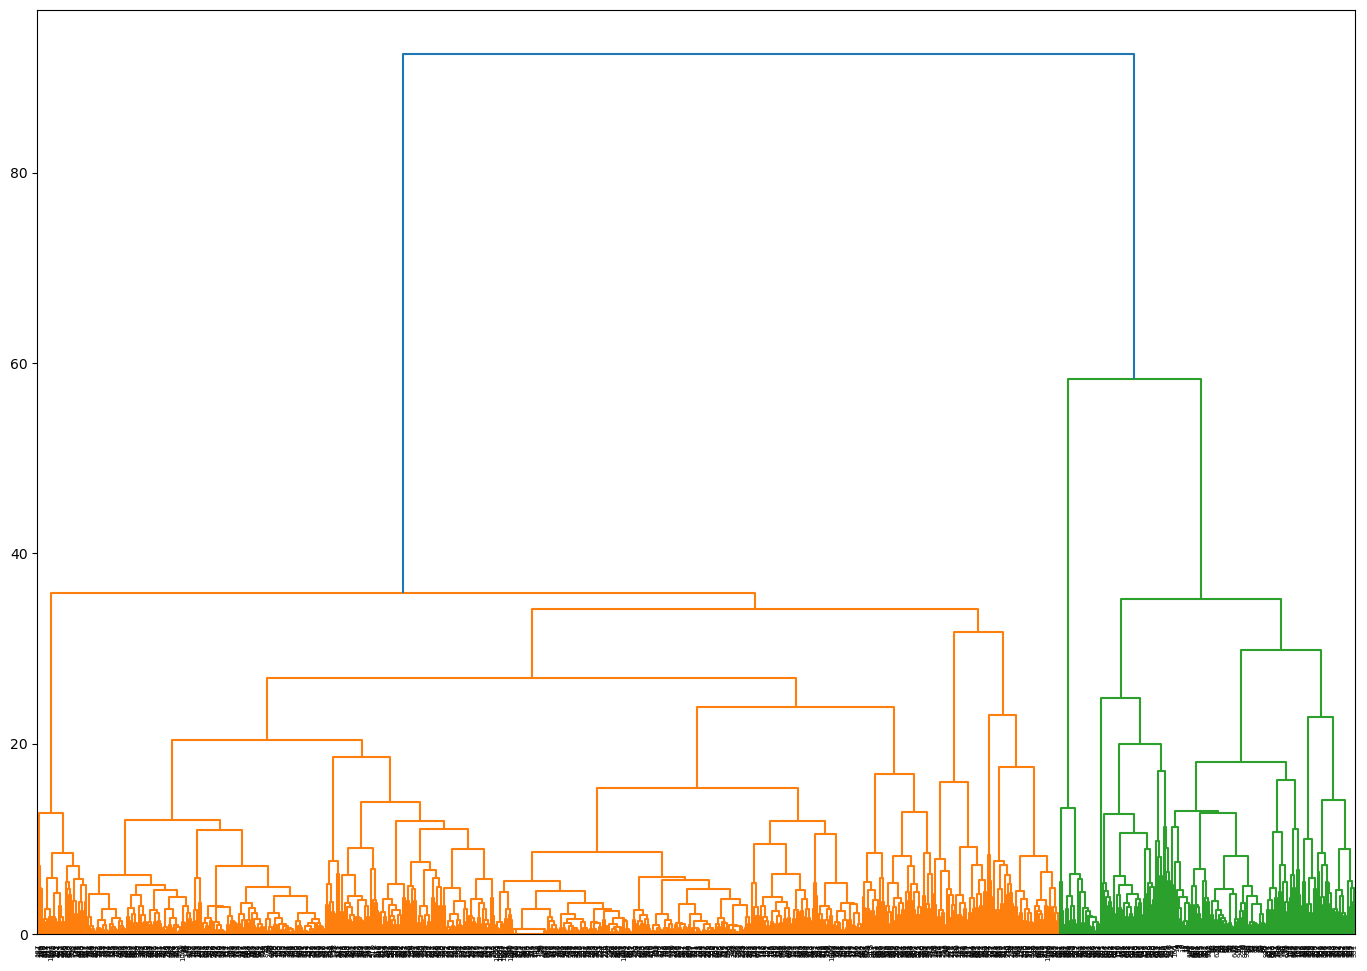

In [10]:
#Standardisation des données
z_scaler = RobustScaler()
X_z = z_scaler.fit_transform(X_features)

#Dendrogramme
hac_dend = linkage(X_z, method='ward', metric='euclidean')
plt.figure(figsize=(17,12))
dendrogram(hac_dend)
plt.show()

##### Obtention 2 clusters mais 3 clusters semblent aussi intéressants

### Classification hiérarchique ascendante à 3 clusters

In [11]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X_z)
labels = model.labels_

X['Cluster_Label'] = labels
X['Cluster_Label'].value_counts()

0    783
1    195
2     32
Name: Cluster_Label, dtype: int64

In [13]:
X['Cluster_Label'] = X['Cluster_Label'].replace({i: 'Cluster '+str(i+1) for i in range(len(X['Cluster_Label'].unique()))})

In [16]:
def valeur_test_cluster_quali(cluster, sportif, s):
    n_ = len(s)
    n_g = len(s[s['Cluster_Label']==cluster])
    
    p_l = len(s[s['sportif']==sportif]) / n_
    p_lg = len(s[(s['Cluster_Label']==cluster) & (s['sportif']==sportif)]) / n_g

    num = p_lg - p_l
    den_div = (n_ - n_g) / (n_ - 1)
    den = np.sqrt(den_div * p_l * (1 - p_l))

    v_test = np.sqrt(n_g) * (num / den)
    return v_test

#Attribution des clusters (valeurs test qualitatives des joueurs)
dict_cl = {}
for cl in X.Cluster_Label.unique():
    dict_cl[cl] = [valeur_test_cluster_quali(cl, s, X[['sportif', 'Cluster_Label']]) for s in X.sportif.unique()]
        
df_sp_cluster = pd.DataFrame(dict_cl, index=X.sportif.unique())
df_sp_cluster['Attribution Cluster'] = df_sp_cluster.idxmax(axis=1)
df_sp_cluster = df_sp_cluster.sort_values(by='Attribution Cluster')
df_sp_cluster

,Cluster 2,Cluster 1,Cluster 3,Attribution Cluster
Joueur-15,-3.155210,3.473136,-1.166797,Cluster 1
Joueur-27,-3.236466,3.185172,-0.297430,Cluster 1
Joueur-26,-2.718515,2.992438,-1.005307,Cluster 1
Joueur-25,-2.535353,2.911965,-1.226278,Cluster 1
Joueur-23,-3.113915,3.427680,-1.151526,Cluster 1
Joueur-22,-3.155210,3.473136,-1.166797,Cluster 1
Joueur-21,-3.155210,3.473136,-1.166797,Cluster 1
Joueur-18,-2.900004,3.192215,-1.072422,Cluster 1
Joueur-16,-2.700364,3.036631,-1.151526,Cluster 1
Joueur-14,-3.072152,3.381709,-1.136082,Cluster 1


### Tableau descriptif des clusters (médianes et différences par cluster)

In [17]:
df_recap_cluster = pd.DataFrame(columns=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Global'], index=marqueurs)

for col in df_recap_cluster.columns:
    for m in marqueurs:
        diff = X.loc[X['Cluster_Label']==col, m].median() - X[m].median()
        df_recap_cluster.loc[m,col] = [np.round(diff,2), X.loc[X['Cluster_Label']==col, m].median()]
        df_recap_cluster.loc[m, 'Global'] = X[m].median()

In [19]:
df_recap_cluster = df_recap_cluster.rename({'Cluster 1': 'Cluster 1 [diff, médiane]',
                                            'Cluster 2': 'Cluster 2 [diff, médiane]',
                                            'Cluster 3': 'Cluster 3 [diff, médiane]', 
                                            'Global': 'Global (médiane)'}, axis='columns')

df_recap_cluster.style.set_properties(**{'text-align': 'center'})

,"Cluster 1 [diff, médiane]","Cluster 2 [diff, médiane]","Cluster 3 [diff, médiane]",Global (médiane)
marqueur1,"[-0.3, 2.8]","[1.4, 4.5]","[-0.75, 2.3499999999999996]",3.1
marqueur2,"[0.0, 1.0]","[1.1, 2.1]","[0.0, 1.0]",1.0
marqueur3,"[-0.1, 4.6]","[0.2, 4.9]","[-0.6, 4.1]",4.7
marqueur4,"[0.0, 4.4]","[0.5, 4.9]","[-1.15, 3.25]",4.4
marqueur5,"[0.0, 1.0]","[1.6, 2.6]","[0.0, 1.0]",1.0
marqueur6,"[0.0, 1.0]","[1.4, 2.4]","[0.0, 1.0]",1.0
marqueur7,"[0.0, 1.0]","[1.7, 2.7]","[8.8, 9.8]",1.0
marqueur8,"[0.0, 1.0]","[1.6, 2.6]","[0.0, 1.0]",1.0
marqueur9,"[0.0, 1.0]","[1.4, 2.4]","[0.0, 1.0]",1.0
marqueur10,"[0.0, 1.0]","[1.3, 2.3]","[0.0, 1.0]",1.0


### ACP pour visualiser les clusters
#### On vérifie la pertinence des variables avec le test de Kaiser-Meyer-Olkin (KMO)

In [20]:
kmo_all, kmo_model = calculate_kmo(X_features)
print('Overall Test de KMO : {}'.format(kmo_model))
pd.DataFrame(index=marqueurs, data=kmo_all, columns=['Test KMO'])

Overall Test de KMO : 0.8420527726564523


,Test KMO
marqueur1,0.826578
marqueur2,0.844334
marqueur3,0.571903
marqueur4,0.591897
marqueur5,0.846264
marqueur6,0.869235
marqueur7,0.864011
marqueur8,0.782737
marqueur9,0.934294
marqueur10,0.896762


##### Le test de KMO est faible pour 'marqueur16' et 'marqueur18'. Le test de KMO est à la limite de l'acceptable pour 'marqueur3' et 'marqueur4', on va tout de même conserver 'marqueur4. Le KMO général est excellent

In [21]:
X_pca = X_features.drop(columns=['marqueur3', 'marqueur16', 'marqueur18'])

In [22]:
#Standardisation des données
pca_scaler = RobustScaler()
X_pca_scaled = pca_scaler.fit_transform(X_pca)

#ACP
pca = PCA(n_components=5)
X_new = pca.fit_transform(X_pca_scaled)

In [25]:
X_new_final = pd.DataFrame(X_new, columns=['PC1','PC2','PC3','PC4','PC5'])
X_new_final['Cluster'] = labels
X_new_final['Cluster'] = X_new_final['Cluster'].replace(
    {i: 'Cluster '+str(i+1) for i in range(len(X_new_final['Cluster'].unique()))})
X_new_final

,PC1,PC2,PC3,PC4,PC5,Cluster
0,2.180927,-1.282654,0.347606,0.236999,0.803261,Cluster 2
1,1.222159,-1.542240,-3.196222,-0.599730,1.754437,Cluster 2
2,1.220163,-0.437382,1.294117,1.883946,-0.352091,Cluster 1
3,6.271832,-0.499001,0.698059,1.683488,1.131552,Cluster 2
4,2.558662,-1.661260,0.290620,1.655175,0.962184,Cluster 2
...,...,...,...,...,...,...
1005,-2.000657,-0.724210,0.257338,-0.555571,0.697243,Cluster 1
1006,-2.890361,0.901856,-0.023616,-1.595202,1.110329,Cluster 1
1007,-2.098507,0.634857,0.823866,-0.868491,0.277755,Cluster 1
1008,-0.575231,2.591163,-0.452220,-0.090855,0.200967,Cluster 1


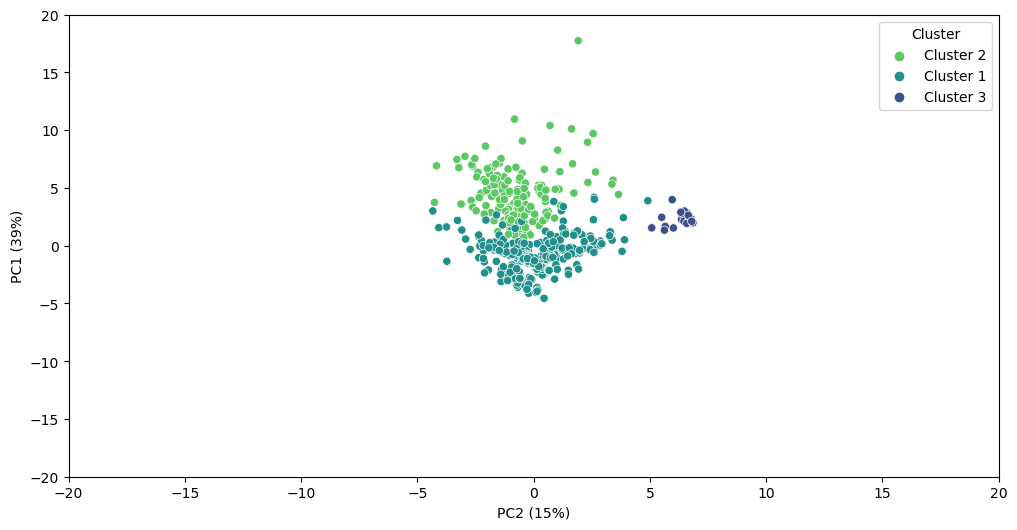

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=X_new_final, x='PC2', y='PC1', hue='Cluster', palette='viridis_r')
plt.ylabel('PC1 (%s%%)' % str(pca.explained_variance_ratio_[0])[:4].lstrip('0.'))
plt.xlabel('PC2 (%s%%)' % str(pca.explained_variance_ratio_[1])[:4].lstrip('0.'))
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.show()

##### On distingue bien nos 3 clusters et on peut constater que le cluster 1 a tendance à saisir en-dessous des autres et le cluster 2 majoritairement au dessus

In [33]:
print(f'Les 2 premières CP expliquent {round(100*(np.cumsum(pca.explained_variance_ratio_)[1]), 0)}% de la variabilité')

Les 2 premières CP expliquent 55.0% de la variabilité


### Distributions des différents marqueurs selon les clusters 

interactive(children=(Dropdown(description='Marqueur', options=('marqueur1', 'marqueur2', 'marqueur3', 'marque…

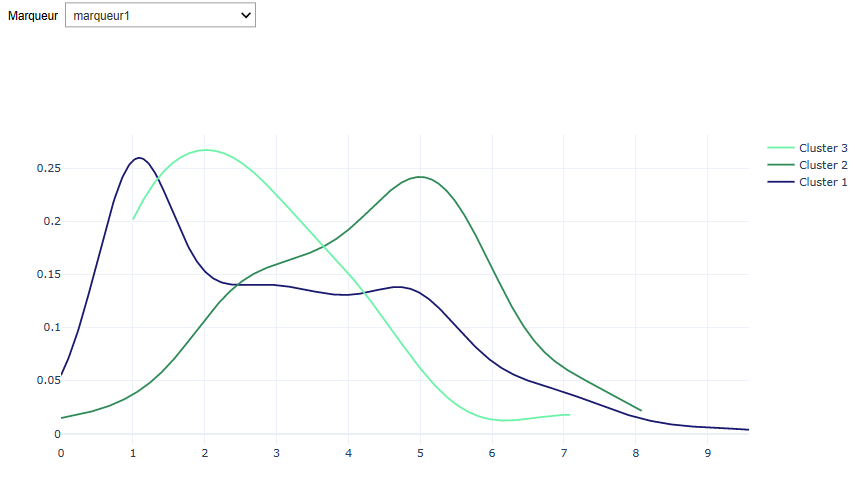

In [37]:
X_plot = X[X['Cluster_Label'] != 'Cluster 4']

def plot(Marqueur):
    fig = ff.create_distplot([X_plot.loc[X_plot['Cluster_Label']==c, Marqueur] for c in np.sort(X_plot['Cluster_Label'].unique())],
                             np.sort(X_plot['Cluster_Label'].unique()),
                             show_rug=False, bin_size=1, show_hist=False, colors=['#191970', '#2E8B57', '#6BF3A8'])
    fig.update_layout(template='plotly_white')
    return fig

widgets.interact(plot, Marqueur=marqueurs)
Image(filename='monitoring3-1.PNG')